In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL as pil
import hashlib
from pickle import dump, load

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

def statistics(index, X, y):
    unique, counts = np.unique(y, return_counts=True)
    print (dict(zip(unique, counts/len(y))))
    plt.bar(unique, counts)
    plt.show()

def evaluate_model(model, train_ds, validation_ds, n_jobs = -1, verbose = 1):
    cross_scores = cross_val_score(model, train_ds[0], train_ds[1], cv=5, 
        scoring='accuracy', n_jobs=n_jobs, verbose=verbose)
    
    model.fit(train_ds[0], train_ds[1])
    validation_score = accuracy_score(validation_ds[1], model.predict(validation_ds[0]))
    return model, cross_scores, validation_score

def create_submission(model, test_index, test_set, filename = 'submission.csv'):
    ans = pd.DataFrame({
        'id': test_index['image'].apply(lambda img: img.replace('test/', '')), 
        'label': model.predict(test_set)
    })
    
    ans.to_csv(filename, index=False)

def BasicPipeline(model_class):
    return Pipeline([
        ('norm', PixelNormalizer()),
        ('train', model_class())
    ])

def PixelNormalizer():
    return FunctionTransformer(lambda pixel: pixel / 255) 

def save_dataset(name, obj):
    with open(f'{name}.pickle', 'wb') as f:
        dump(obj, f)
def reload_dataset(name):
    with open(f'{name}.pickle', 'rb') as f:
        return load(f)

def hash_obj(obj):
    r = repr(obj).encode('utf-8')
    h = hashlib.md5()
    h.update(r)
    return h.hexdigest()

def read_img(filename):
    img = np.array(pil.Image.open(filename), dtype=np.uint8)
    img = np.reshape(img, (-1))
    return img

def check_hash(data, h):
    return hash_obj(data) == h

def check_img_list_hash(imgs, hashes):
    return len(imgs) == len(hashes) and all([hash_obj(img) == h for img, h in zip(imgs, hashes)])

def load_dataset(dataset_name, load_labels = True):
    index = pd.read_csv(f"{dataset_name}.txt", header=None, names=['image', 'label', 'hash'])
    index['image'] = index['image'].apply(lambda filename: f"{dataset_name}/{filename}")
    
    assert len(index['image']) == 30001 or len(index['image']) == 5000
    
    if load_labels:
        labels = np.array(index["label"], dtype=np.uint8)
        labels = np.reshape(labels, (-1))
    else:
        labels = None
    
    images = [read_img(filename) for filename in index['image']]
    images = np.array(images)
    
    index['hash'] = [hash_obj(img) for img in images]
    
    return index, images, labels

In [2]:
# Reload data
train_index, train_set, train_labels = reload_dataset('train')
validation_index, validation_set, validation_labels = reload_dataset('validation')
test_index, test_set, _ = reload_dataset('test')

# Check integrity
check_img_list_hash(test_set, test_index['hash'])

True

{0: 0.11082963901203294, 1: 0.11082963901203294, 2: 0.10806306456451452, 3: 0.11169627679077364, 4: 0.11452951568281057, 5: 0.11022965901136629, 6: 0.1144295190160328, 7: 0.10779640678644045, 8: 0.11159628012399586}


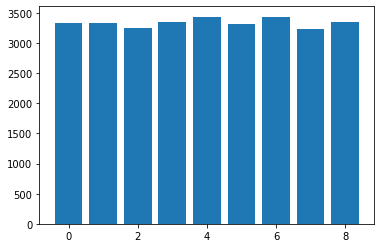

{0: 0.114, 1: 0.1054, 2: 0.1066, 3: 0.1156, 4: 0.1108, 5: 0.1122, 6: 0.116, 7: 0.104, 8: 0.1154}


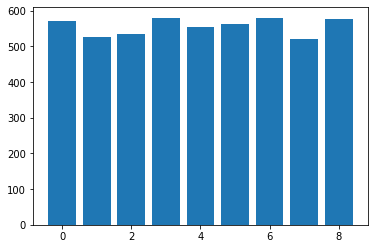

In [3]:
statistics(train_index, train_set, train_labels)
statistics(validation_index, validation_set, validation_labels)

{0: 0.10666666666666667, 1: 0.1055, 2: 0.10966666666666666, 3: 0.11366666666666667, 4: 0.1125, 5: 0.10966666666666666, 6: 0.12316666666666666, 7: 0.11333333333333333, 8: 0.10583333333333333}


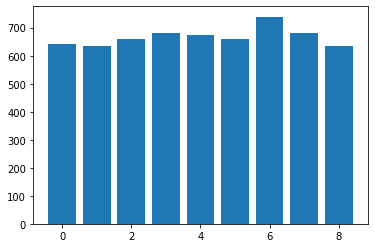

In [4]:
from sklearn.model_selection import ShuffleSplit

ss = ShuffleSplit(n_splits = 1, train_size = 0.2, random_state=42)
indices, _ = next(ss.split(train_set, train_labels, train_labels))
part_train_set, part_train_labels = train_set[indices], train_labels[indices]

statistics(train_index.iloc[indices], part_train_set, part_train_labels)

In [8]:
basic = BasicPipeline(SGDClassifier)
results = evaluate_model(basic, (train_set, train_labels), (validation_set, validation_labels), n_jobs=2, verbose=10)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   36.2s
[Parallel(n_jobs=2)]: Done   3 out of   5 | elapsed:  1.2min remaining:   46.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.7min finished


In [15]:
results

(Pipeline(steps=[('norm',
                  FunctionTransformer(func=<function PixelNormalizer.<locals>.<lambda> at 0x7f1fe28cf4d0>)),
                 ('train', SGDClassifier())]),
 array([0.53491085, 0.53833333, 0.50633333, 0.53416667, 0.5405    ]),
 0.5574)

In [14]:
create_submission(basic, test_index, test_set, 'sgdc_basic.csv')

In [18]:
svm_basic = BasicPipeline(SVC)
results_svm = evaluate_model(svm_basic, (train_set, train_labels), (validation_set, validation_labels), n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 14.4min remaining: 21.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 14.6min remaining:  9.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 20.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 20.7min finished


In [21]:
results_svm

(Pipeline(steps=[('norm',
                  FunctionTransformer(func=<function PixelNormalizer.<locals>.<lambda> at 0x7f200d58c440>)),
                 ('train', SVC())]),
 array([0.72854524, 0.73766667, 0.73383333, 0.72816667, 0.72816667]),
 0.735)

In [20]:
create_submission(svm_basic, test_index, test_set, 'svm_basic.csv')

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Trying [-1, 1] scaling as suggested in https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf
svm_min_max = Pipeline([
    ('scale', MinMaxScaler((-1, 1))),
    ('train', SVC()),
])
results_svm_min_max = evaluate_model(svm_min_max, (train_set, train_labels), (validation_set, validation_labels), n_jobs=-1, verbose=10)
results_svm_min_max

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 14.4min remaining: 21.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 14.4min remaining:  9.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 19.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 19.9min finished


(Pipeline(steps=[('scale', MinMaxScaler(feature_range=(-1, 1))),
                 ('train', SVC())]),
 array([0.72854524, 0.73766667, 0.73383333, 0.72816667, 0.72816667]),
 0.735)

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

def pow_range(base, start, stop, step):
    return [base**i for i in range(start, stop, step)]

C_range = pow_range(2, -5, 15+1, 2)
gamma_range = pow_range(2, -15, 3+1, 2)

svm_min_max_rbf = Pipeline([
    ('scale', MinMaxScaler((-1, 1))),
    ('train', SVC(kernel = 'rbf', random_state = 42)),
])

grid = [
    {
        'train__C': list(C_range),
        'train__gamma': list(gamma_range),
    },
]

svm_min_max_rbf_grid = GridSearchCV(svm_min_max_rbf, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy', verbose=10)

In [ ]:
svm_min_max_rbf_grid.fit(part_train_set, part_train_labels)

Fitting 5 folds for each of 110 candidates, totalling 550 fits
